In [2]:
import pandas as pd
import feather
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,8)

from ordinal_tsf.model import MordredStrategy
from ordinal_tsf.dataset import Dataset, Quantiser, Standardiser, OrdinalPrediction


import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
np.random.seed(1)

# Introduction

### In this notebook, we show how to use our pre-trained models to predict time series, even when there are few observations at hand.

### Our example predicts the quasi-seasonal component of the  CO$_2$ data from the $\href{https://www.esrl.noaa.gov/gmd/ccgg/trends/}{\text{Mauna Loa observatory}}$.

### This dataset only has about 500 training examples (excluding the validation and testing segments).

Dataset has 446 unique values.


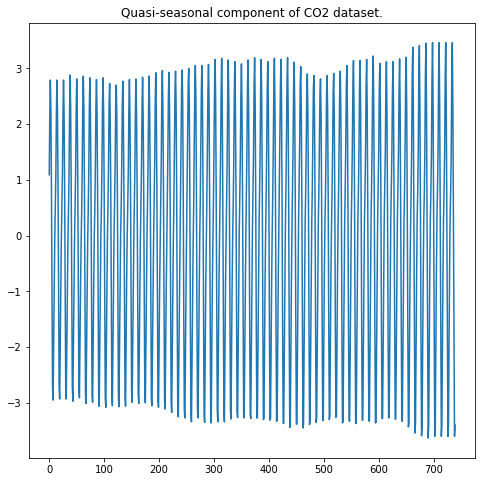

In [3]:
co2_pd = pd.read_csv('co2_data.csv')
seasonal_ts = (co2_pd['interpolated'] - co2_pd['trend']).values[:, np.newaxis]

print('Dataset has {} unique values.'.format(np.unique(seasonal_ts).shape[0]))
plt.plot(seasonal_ts)
plt.title('Quasi-seasonal component of CO2 dataset.')
plt.show()

### We start by making our data zero-mean and unit variance and quantising it, as shown in our previous example notebook.

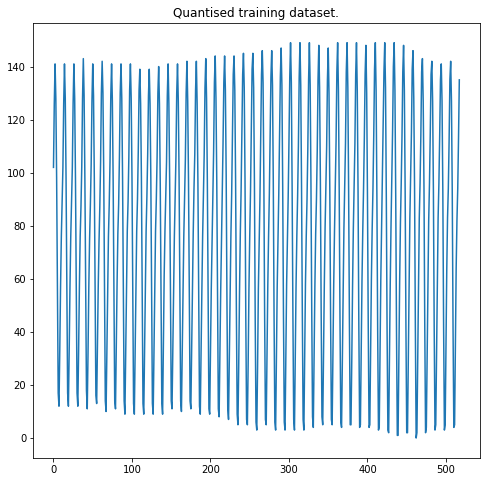

In [4]:
LOOKBACK = 20
HORIZON = 20
N_BINS = 150
frame_length = LOOKBACK + HORIZON + 1

stand = Standardiser()
x = Dataset(seasonal_ts, frame_length, preprocessing_steps=[stand])


quant = Quantiser(150)
quant.fit(x.train_ts[:, 0])
x_quant = Dataset(seasonal_ts, frame_length, preprocessing_steps=[stand, quant])

plt.plot(x_quant.train_ts.argmax(axis=-1))
plt.title('Quantised training dataset.')
plt.show()

# A MOrdReD model trained from scratch doesn't do well on this dataset

Epoch 1/100
 - 3s - loss: 5.0292 - categorical_crossentropy: 5.0118 - val_loss: 5.0128 - val_categorical_crossentropy: 4.9963
Epoch 2/100
 - 0s - loss: 5.0110 - categorical_crossentropy: 4.9945 - val_loss: 4.9995 - val_categorical_crossentropy: 4.9836
Epoch 3/100
 - 0s - loss: 4.9977 - categorical_crossentropy: 4.9818 - val_loss: 4.9819 - val_categorical_crossentropy: 4.9665
Epoch 4/100
 - 0s - loss: 4.9772 - categorical_crossentropy: 4.9619 - val_loss: 4.9351 - val_categorical_crossentropy: 4.9202
Epoch 5/100
 - 0s - loss: 4.9307 - categorical_crossentropy: 4.9158 - val_loss: 4.6741 - val_categorical_crossentropy: 4.6595
Epoch 6/100
 - 0s - loss: 4.7101 - categorical_crossentropy: 4.6955 - val_loss: 4.5720 - val_categorical_crossentropy: 4.5576
Epoch 7/100
 - 0s - loss: 4.6190 - categorical_crossentropy: 4.6045 - val_loss: 4.5540 - val_categorical_crossentropy: 4.5397
Epoch 8/100
 - 0s - loss: 4.5580 - categorical_crossentropy: 4.5437 - val_loss: 4.5454 - val_categorical_crossentropy:

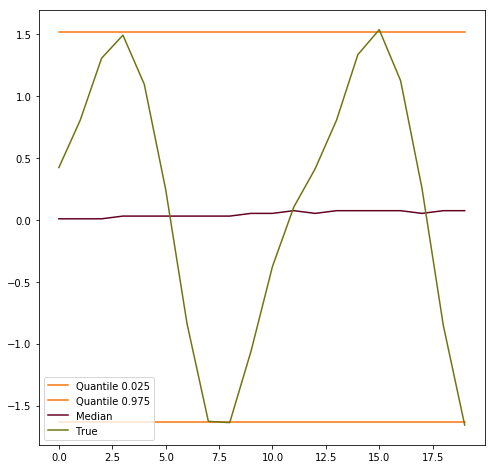

In [6]:
train_spec = {'epochs':100, 'batch_size': 64}
model_scratch = MordredStrategy(ordinal_bins=150, units=256, dropout_rate=0.35, 
                                lam=1e-5, lookback=LOOKBACK, horizon=HORIZON)
model_scratch.fit(x_quant.train_frames, **train_spec)

pred = model_scratch.predict(x_quant.val_ts[np.newaxis, :HORIZON+1], predictive_horizon=HORIZON)
pred['bins'] = quant.bins
ord_pred = OrdinalPrediction(**pred)
ax = plt.subplot()
ord_pred.plot_median_2std(ax, x.val_ts[LOOKBACK+1:2*LOOKBACK+1])
plt.show()

# But using one of our pre-trained models, we can achieve better performance

### Our pre-trained models can be found in the "pretrained" folder, and they are grouped into "short lookback" (20 samples) and "medium lookback" (50 samples). 

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Epoch 1/100
 - 3s - loss: 6.3865 - categorical_crossentropy: 6.1341 - val_loss: 5.8176 - val_categorical_crossentropy: 5.5661
Epoch 2/100
 - 0s - loss: 6.1093 - categorical_crossentropy: 5.8579 - val_loss: 5.6429 - val_categorical_crossentropy: 5.3921
Epoch 3/100
 - 0s - loss: 5.9301 - categorical_crossentropy: 5.6793 - val_loss: 5.4665 - val_categorical_crossentropy: 5.2163
Epoch 4/100
 - 0s - loss: 5.7743 - categorical_crossentropy: 5.5241 - val_loss: 5.3155 - val_categorical_crossentropy: 5.0658
Epoch 5/100
 - 0s - loss: 5.6643 - categorical_crossentropy: 5.4146 - val_loss: 5.2112 - val_categorical_crossentropy: 4.9621
Epoch 6/100
 - 0s - loss: 5.5231 - categorical_crossentropy: 5.2741 - val_loss: 5.1254 - val_categorical_crossentropy: 4.8768
Epoch 7/100
 - 0s - loss: 5.3972 - categorical_crossentropy: 5.1487 - val_loss: 5.0250 - val_categorical_crossentropy: 4.7770
Epoch 8/100
 - 0s - loss: 5.3049 - categorical_crossentropy: 5.0569 - val_loss: 4.9326 - val_categorical_crossentropy:

Epoch 66/100
 - 0s - loss: 2.1740 - categorical_crossentropy: 1.9466 - val_loss: 1.9761 - val_categorical_crossentropy: 1.7489
Epoch 67/100
 - 0s - loss: 2.0518 - categorical_crossentropy: 1.8246 - val_loss: 1.9624 - val_categorical_crossentropy: 1.7354
Epoch 68/100
 - 0s - loss: 2.0244 - categorical_crossentropy: 1.7974 - val_loss: 1.9528 - val_categorical_crossentropy: 1.7260
Epoch 69/100
 - 0s - loss: 2.0158 - categorical_crossentropy: 1.7891 - val_loss: 1.9441 - val_categorical_crossentropy: 1.7176
Epoch 70/100
 - 0s - loss: 2.0338 - categorical_crossentropy: 1.8073 - val_loss: 1.9427 - val_categorical_crossentropy: 1.7164
Epoch 71/100
 - 0s - loss: 1.9953 - categorical_crossentropy: 1.7690 - val_loss: 1.9465 - val_categorical_crossentropy: 1.7205
Epoch 72/100
 - 0s - loss: 1.9951 - categorical_crossentropy: 1.7691 - val_loss: 1.9230 - val_categorical_crossentropy: 1.6971
Epoch 73/100
 - 0s - loss: 1.9673 - categorical_crossentropy: 1.7415 - val_loss: 1.9209 - val_categorical_cross

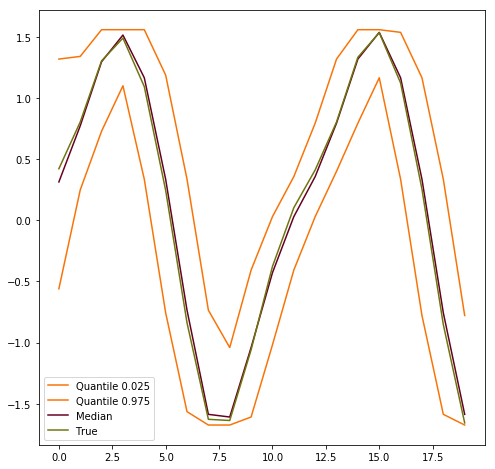

In [5]:
train_spec = {'epochs':100, 'batch_size': 64}
this_fname = 'ordinal_tsf/pretrained/lookback20/gum_20_150_bins_256_hidden_0.5_dropout_1e-05_l2'
model = MordredStrategy.load(this_fname)
model.fit(x_quant.train_frames, **train_spec)

pred = model.predict(x_quant.val_ts[np.newaxis, :HORIZON+1], predictive_horizon=HORIZON)
pred['bins'] = quant.bins
ord_pred = OrdinalPrediction(**pred)

ax = plt.subplot()
ord_pred.plot_median_2std(ax, x.val_ts[LOOKBACK+1:2*LOOKBACK+1])
plt.show()